In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
sns.set(style="whitegrid")

In [ ]:
file_path = "data/csv/results_augmented_rdkit.csv"
df = pd.read_csv(file_path)

In [5]:
print("DataFrame Info:")
print(df.info())

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1937 entries, 0 to 1936
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ligand_id  1937 non-null   int64  
 1   conf_id    1937 non-null   int64  
 2   logp       1937 non-null   float64
 3   rmsd       1734 non-null   float64
 4   energy     1796 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 75.8 KB
None


In [6]:
df['ligand_id'] = df['ligand_id'].astype(str)
df['conf_id'] = pd.to_numeric(df['conf_id'], errors='coerce')
df['logp'] = pd.to_numeric(df['logp'], errors='coerce')
df['rmsd'] = pd.to_numeric(df['rmsd'], errors='coerce')
df['energy'] = pd.to_numeric(df['energy'], errors='coerce')

In [7]:
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
ligand_id      0
conf_id        0
logp           0
rmsd         203
energy       141
dtype: int64


In [8]:
df_clean = df.dropna(subset=['logp', 'rmsd', 'energy'])

In [9]:
base = df_clean[df_clean['conf_id'] == 0][['ligand_id', 'logp', 'energy']].rename(
    columns={'logp': 'base_logp', 'energy': 'base_energy'}
)

In [10]:
df_merged = df_clean.merge(base, on='ligand_id', how='left')


In [11]:
df_merged

,ligand_id,conf_id,logp,rmsd,energy,base_logp,base_energy
0,4020018,0,-1.936941,0.000000,445.863401,-1.936941,445.863401
1,4020018,1,-2.918744,0.814124,236.864495,-1.936941,445.863401
2,4020018,2,-3.062183,1.509390,249.620198,-1.936941,445.863401
3,4020018,3,-2.965745,0.420024,233.352226,-1.936941,445.863401
4,4020018,4,-2.944824,0.909806,235.717865,-1.936941,445.863401
...,...,...,...,...,...,...,...
1588,4029064,25,-5.990614,1.386061,81.119065,-5.003605,249.789758
1589,4029064,26,-6.089917,1.205437,90.943219,-5.003605,249.789758
1590,4029064,27,-5.816219,0.914125,91.754593,-5.003605,249.789758
1591,4029064,28,-5.899748,0.953061,88.526026,-5.003605,249.789758


In [12]:
df_merged['delta_logp'] = df_merged['logp'] - df_merged['base_logp']
df_merged['delta_energy'] = df_merged['energy'] - df_merged['base_energy']

In [13]:
df_diffs = df_merged[df_merged['conf_id'] != 0]

In [14]:
df['logp_rank'] = df.groupby('ligand_id')['logp'].rank(ascending=False,method='min')
df['energy_rank'] = df.groupby('ligand_id')['energy'].rank(method='min')


In [15]:
def extract_base_ranks(group):
    base = group[group['conf_id'] == 0]
    if base.empty:
        return pd.Series({col: None for col in [
            'logp_rank_base', 'energy_rank_base',
            'logp_top_1', 'logp_top_3', 'logp_top_5',
            'energy_top_1', 'energy_top_3', 'energy_top_5'
        ]})
    
    logp_rank = base['logp_rank'].values[0]
    energy_rank = base['energy_rank'].values[0]
    
    return pd.Series({
        'logp_rank_base': logp_rank,
        'energy_rank_base': energy_rank,
        'logp_top_1': logp_rank == 1,
        'logp_top_3': logp_rank <= 3,
        'logp_top_5': logp_rank <= 5,
        'energy_top_1': energy_rank == 1,
        'energy_top_3': energy_rank <= 3,
        'energy_top_5': energy_rank <= 5
    })


In [16]:
rank_summary = df.groupby('ligand_id').apply(extract_base_ranks).reset_index()



In [17]:
accuracy = rank_summary[
    ['logp_top_1', 'logp_top_3', 'logp_top_5', 'energy_top_1', 'energy_top_3', 'energy_top_5']
].mean()
print("Prediction Accuracy (Fraction of Ligands):")
print(accuracy)



Prediction Accuracy (Fraction of Ligands):
logp_top_1      0.878788
logp_top_3      0.898990
logp_top_5      0.919192
energy_top_1    0.252525
energy_top_3    0.252525
energy_top_5    0.262626
dtype: float64


In [18]:
plot_df = accuracy.reset_index()
plot_df.columns = ['metric', 'fraction']
plot_df['method'] = plot_df['metric'].apply(lambda x: 'logP' if 'logp' in x else 'energy')
plot_df['rank_cutoff'] = plot_df['metric'].str.extract(r'top_(\d)').astype(int)


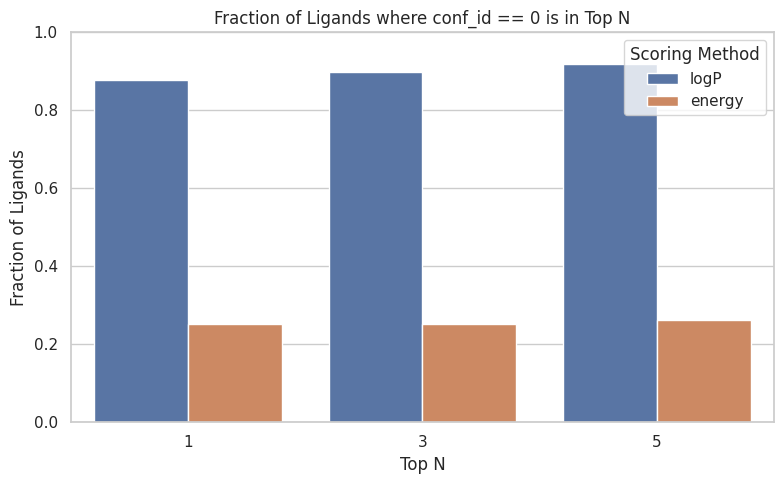

In [19]:
plt.figure(figsize=(8, 5))
sns.barplot(data=plot_df, x='rank_cutoff', y='fraction', hue='method')
plt.title("Fraction of Ligands where conf_id == 0 is in Top N")
plt.ylabel("Fraction of Ligands")
plt.xlabel("Top N")
plt.ylim(0, 1)
plt.legend(title="Scoring Method")
plt.tight_layout()
plt.show()

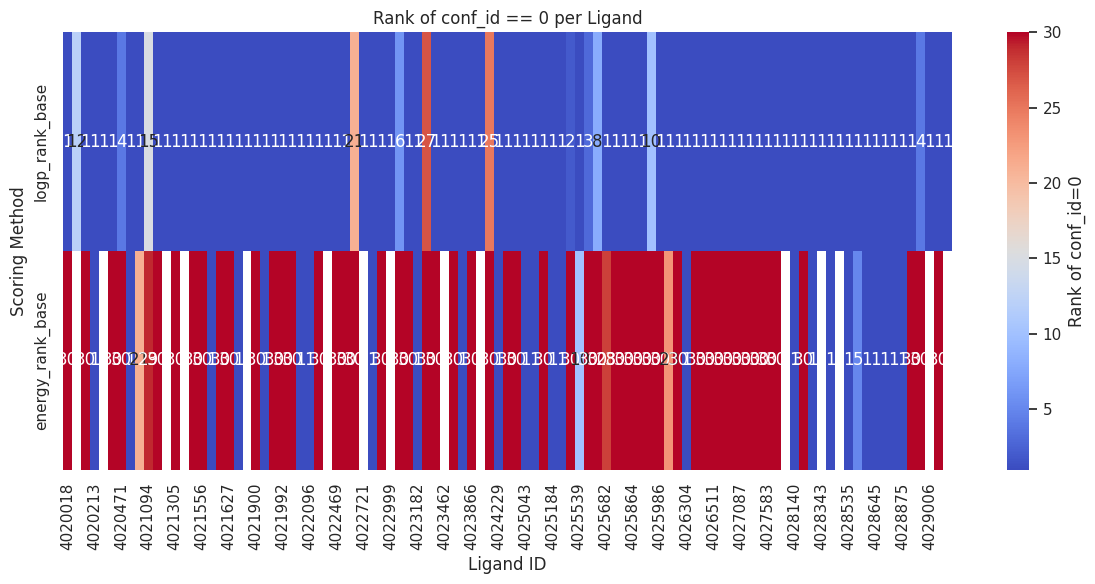

In [20]:
pivot = rank_summary[['ligand_id', 'logp_rank_base', 'energy_rank_base']].set_index('ligand_id')
plt.figure(figsize=(12, 6))
sns.heatmap(pivot.T, annot=True, cmap="coolwarm", cbar_kws={'label': 'Rank of conf_id=0'})
plt.title("Rank of conf_id == 0 per Ligand")
plt.xlabel("Ligand ID")
plt.ylabel("Scoring Method")
plt.tight_layout()
plt.show()

In [21]:
import os
import subprocess

def get_atom_count_from_cif_obabel(cif_path):
    try:
        result = subprocess.run(
            ["obabel", "-icif", cif_path, "-osmi"],
            capture_output=True, text=True, check=True
        )
        smiles = result.stdout.strip()
        if smiles:
            atom_count = sum(1 for c in smiles if c.isalpha() and c.isupper())
            return atom_count
        else:
            raise ValueError("No SMILES generated")
    except subprocess.CalledProcessError as e:
        print(f"Open Babel error on {cif_path}: {e.stderr}")
        return None
    except Exception as e:
        print(f"General error on {cif_path}: {e}")
        return None


In [22]:
# import pandas as pd

# cif_dir = "data/cif"
# entries = []

# for filename in os.listdir(cif_dir):
#     if filename.endswith(".cif"):
#         ligand_id = os.path.splitext(filename)[0]
#         cif_path = os.path.join(cif_dir, filename)
#         atom_count = get_atom_count_from_cif_obabel(cif_path)
#         entries.append({'ligand_id': ligand_id, 'atom_count': atom_count})

# size_df = pd.DataFrame(entries)
# size_df = size_df.dropna(subset=['atom_count'])
# size_df.to_csv("ligand_sizes.csv", index=False)
# print("Saved ligand_sizes.csv")


In [23]:
df['logp_rank'] = df.groupby('ligand_id')['logp'].rank(ascending=False, method='min')
df['energy_rank'] = df.groupby('ligand_id')['energy'].rank(ascending=True, method='min')


In [24]:
n_confs = df.groupby('ligand_id')['conf_id'].count().rename('n_confs')


In [25]:
base_ranks = df[df['conf_id'] == 0][['ligand_id', 'logp_rank', 'energy_rank']].set_index('ligand_id')
base_ranks = base_ranks.join(n_confs)


In [26]:
base_ranks['logp_rank_norm'] = (base_ranks['logp_rank'] - 1) / (base_ranks['n_confs'] - 1)
base_ranks['energy_rank_norm'] = (base_ranks['energy_rank'] - 1) / (base_ranks['n_confs'] - 1)



In [27]:
# Load ligand sizes from CSV
ligand_sizes = pd.read_csv("ligand_sizes.csv")  # contains 'ligand_id', 'atom_count'

ligand_sizes['ligand_id'] = ligand_sizes['ligand_id'].astype(str)

# Merge into base_ranks
base_ranks = base_ranks.reset_index().merge(ligand_sizes, on='ligand_id', how='left')

# Drop entries where size is missing
base_ranks = base_ranks.dropna(subset=['atom_count'])

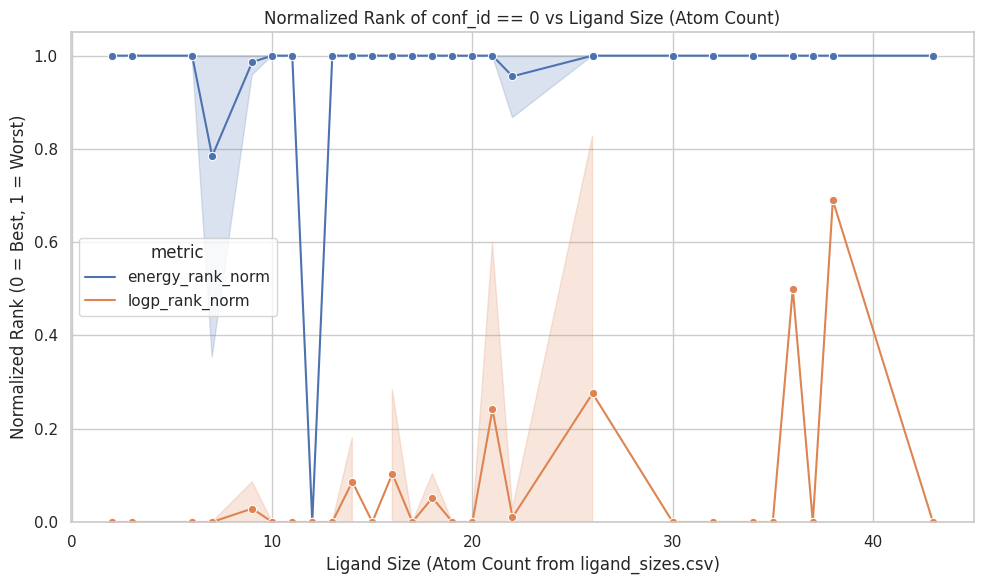

In [28]:
melted = base_ranks[['ligand_id', 'atom_count', 'logp_rank_norm', 'energy_rank_norm']] \
    .melt(id_vars=['ligand_id', 'atom_count'],
          value_vars=['logp_rank_norm', 'energy_rank_norm'],
          var_name='metric', value_name='norm_rank')

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(data=melted.sort_values('atom_count'), x='atom_count', y='norm_rank', hue='metric', marker='o')

plt.title("Normalized Rank of conf_id == 0 vs Ligand Size (Atom Count)")
plt.xlabel("Ligand Size (Atom Count from ligand_sizes.csv)")
plt.ylabel("Normalized Rank (0 = Best, 1 = Worst)")
plt.ylim(0, 1.05)
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
not_best_ligands = base_ranks[base_ranks['energy_rank'] != 1]['ligand_id'].tolist()

# Get all conformers for those ligands
bad_base_confs = df[df['ligand_id'].isin(not_best_ligands)]

# Optional: only show conf_id == 0 from those
bad_conf0 = bad_base_confs[bad_base_confs['conf_id'] == 0]

# Save or print
bad_conf0[['ligand_id', 'conf_id', 'logp_rank', 'energy_rank']]

,ligand_id,conf_id,logp_rank,energy_rank
0,4020018,0,1.0,30.0
30,4020157,0,12.0,NaN
60,4020177,0,1.0,30.0
91,4020399,0,1.0,NaN
92,4020437,0,1.0,30.0
...,...,...,...,...
1845,4028887,0,1.0,30.0
1875,4028935,0,4.0,30.0
1905,4029006,0,1.0,NaN
1906,4029064,0,1.0,30.0


In [30]:
rmsd_mean = df[df['conf_id'] != 0].groupby('ligand_id')['rmsd'].mean().reset_index()
rmsd_mean = rmsd_mean.rename(columns={'rmsd': 'mean_rmsd_others'})

In [31]:
rmsd_mean

,ligand_id,mean_rmsd_others
0,4020018,0.757610
1,4020157,1.767056
2,4020177,1.718101
3,4020437,0.991474
4,4020471,1.094324
...,...,...
60,4028343,2.852213
61,4028583,1.957296
62,4028887,0.837763
63,4028935,1.507268


In [33]:
rmsd_mean['mean_rmsd_others'].mean()


1.6621499080221478

In [3]:
import pickle
from rdkit import Chem
from collections import defaultdict

# Load the pickled RDKit Mol objects
with open("val_Drugs.pkl", "rb") as f:
    mol_list = pickle.load(f)

# Dictionary to count conformers per unique molecule
conformer_counts = defaultdict(int)

# For each Mol object, use canonical SMILES as key
for mol in mol_list:
    print(mol.GetPropNames())
    smiles = Chem.MolToSmiles(Chem.RemoveHs(mol))  # Remove hydrogens for consistent comparison
    conformer_counts[smiles] += 1

# Print results
for smiles, count in conformer_counts.items():
    print(f"Molecule: {smiles} -> {count} conformers")

# Optional: Summary statistics
print("\nTotal unique molecules:", len(conformer_counts))
print("Total conformers:", len(mol_list))


Molecule: COc1cccc(C(=O)/C=C/Nc2ccc(S(=O)(=O)Nc3nc(C)cc(C)n3)cc2)c1 -> 50 conformers
Molecule: Clc1ccc(CSc2nnc(-c3ccccn3)n2Cc2ccco2)c(Cl)c1 -> 51 conformers
Molecule: COc1ccc(CN(CC(=O)NC2CCCCC2)C(=O)CCC(=O)Nc2nccs2)cc1 -> 287 conformers
Molecule: O=C(O)CCC(=O)Nc1ccccc1N1CCOCC1 -> 131 conformers
Molecule: C[C@]1(C)Cc2c(ccc3ccccc23)C(NNC(=O)c2cccnc2)=N1 -> 17 conformers
Molecule: CCC(C)(C)NC(=O)c1cc(S(=O)(=O)N2CCCCC2)ccc1N1CCOCC1 -> 251 conformers
Molecule: O=C1c2ccccc2C(=O)N1CCCC(=O)N1CCCc2ccccc21 -> 28 conformers
Molecule: C[C@@H]1C[C@H](C)CN(S(=O)(=O)c2ccc(C(=O)NN3CCOCC3)cc2)C1 -> 99 conformers
Molecule: CCN(Cc1ccncc1)C(=O)c1cc(COc2ccc(OC)cc2Cl)on1 -> 208 conformers
Molecule: CCCCC(=O)NC(=S)NNC(=O)CC#N -> 90 conformers

Total unique molecules: 10
Total conformers: 1212


In [2]:
print(mol.GetPropNames())

In [7]:
mol = mol_list[0]

# How many conformers?
print("Number of conformers:", mol.GetNumConformers())

# Look inside the first conformer
conf = mol.GetConformer(0)
print("Conformer type:", type(conf))
print("Conformer dir:", dir(conf))
print("Conformer dict:", getattr(conf, "__dict__", "No __dict__"))

# Just in case, check if any RDKit props exist
print("Conformer has props:", conf.GetNumAtoms(), hasattr(conf, 'GetDoubleProp'))

# If this works, try this too:
try:
    print("Energy property:", conf.GetDoubleProp("energy"))
except:
    print("No 'energy' property found.")


Number of conformers: 1
Conformer type: <class 'rdkit.Chem.rdchem.Conformer'>
Conformer dir: ['ClearComputedProps', 'ClearProp', 'GetAtomPosition', 'GetBoolProp', 'GetDoubleProp', 'GetId', 'GetIntProp', 'GetNumAtoms', 'GetOwningMol', 'GetPositions', 'GetProp', 'GetPropNames', 'GetPropsAsDict', 'GetUnsignedProp', 'HasOwningMol', 'HasProp', 'Is3D', 'Set3D', 'SetAtomPosition', 'SetBoolProp', 'SetDoubleProp', 'SetId', 'SetIntProp', 'SetProp', 'SetUnsignedProp', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__instance_size__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__']
Conformer dict: {}
Conformer has props: 53 True
No 'energy' property found.
